### Introduction

In this project, I will focus on building a model for multi-output learning using the SemEval 2014 Task 1 dataset. This dataset contains text samples, each associated with multiple labels, reflecting complex relationships inherent in real-world data. 

The competition aims to evaluate computational models that measure the similarity between pairs of sentences. Given two text fragments, the goal is to assign a similarity score that reflects their meaning closeness, which is useful in applications such as machine translation, information retrieval, and text summarization.

This project will provide valuable insights into how machine learning can effectively deal with multi-label classification challenges.

### Import neseccery packages

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score
device = "cuda:3" if torch.cuda.is_available() else "cpu"

### SemEval 2014 Task 1 dataset

Task Description: Evaluation of compositional distributional semantic models on full sentences through semantic relatedness and textual entailment.

This challenge involves two sub-tasks:

- sub-task1: predicting the degree of relatedness between two sentences (eg. **regression**)

- sub-task2: detecting the entailment relation holding between them (eg. **3-class classification**)

Dataset describtion: 

- Train split: 4500 pieces

- Validation split: 500 pieces

- Test split: 4927 pieces

- Each data piece: 
    - premise
        
    - hypothesis
        
    - relatedness_score: A numerical score (e.g., from 0 to 5) that indicates the semantic similarity between the premise and the hypothesis.
        
    - entailment_judgement: A categorical label that classifies the relationship between the premise and the hypothesis. (including 3: Contradiction, 2: Entailment, 0: Neutral)

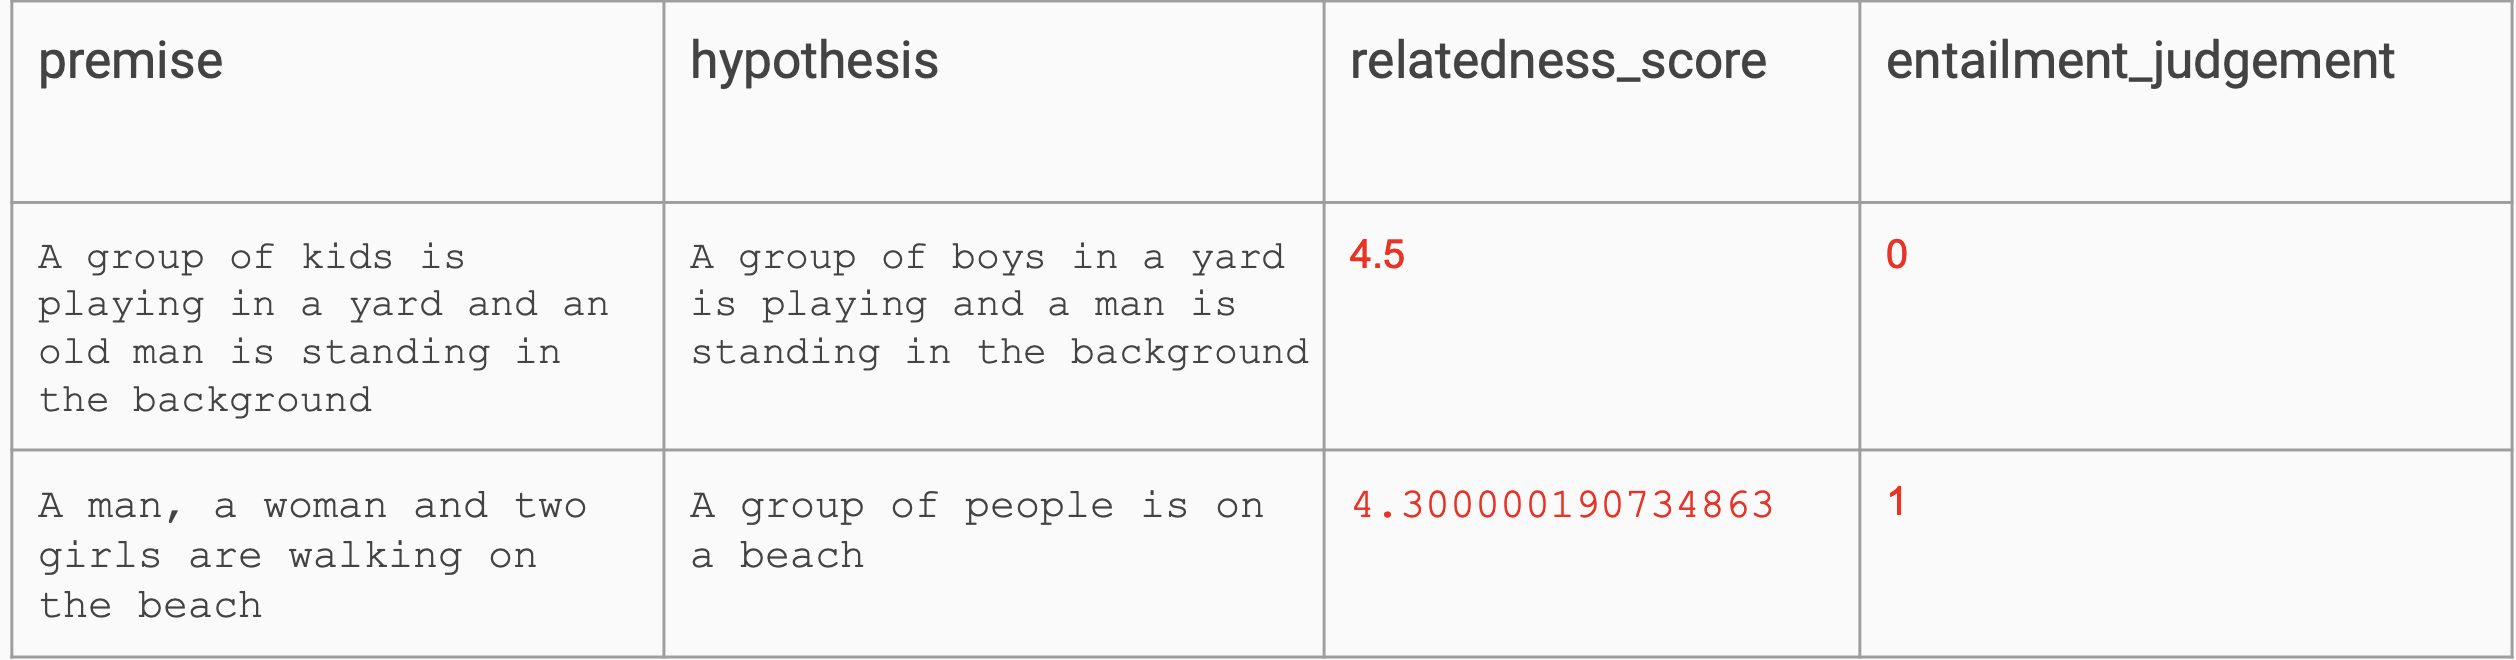

### Data Preprocessing

This pipeline processes the data for use with a BERT-based model. 

1. Define `SemevalDataset` class

    - Loads and processes the SemEval 2014 Task 1 dataset.

    - Maps entailment_judgment to numeric labels and returns cleaned records.

2. Define bert base tokenizer: Uses `BertTokenizer` to convert sentences into BERT-compatible tokens.

3. Define `collate_fn()` function: Prepares batches by tokenizing sentences and converting data into tensors.

    - Handling Variable-Length Sequences: Ensures consistent input length by padding or truncating sentences.

    - Converting to Tensors: Converts tokenized text into tensors, which models require for training.

    - Attention Masks and Token Type IDs: Provides extra information like which tokens to attend to and which sentence they belong to.

4. Build own DataLoader : Creates training and validation DataLoaders, shuffling data for training.



In [69]:
# Step 1: Define SemevalDataset class
token_replacement = [    # turn Chinese punctuation marks into English punctuation marks
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
] 
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        judgment_mapping={'NEUTRAL':0,'ENTAILMENT':1,'CONTRADICTION':2}

        if split == "train":
            read_path = "/Users/user/Downloads/sick_train/SICK_train.txt"
        elif split == "validation":
            read_path = "/Users/user/Downloads/sick_train/SICK_eval.txt"
        elif split == "test":
            read_path = "/Users/user/Downloads/sick_train/SICK_test_annotated.txt"
        
        self.data = pd.read_table(read_path)
        self.data["entailment_judgment"] = self.data["entailment_judgment"].map(judgment_mapping) # mapping entailment_judgment
        self.data = self.data.to_dict(orient="records")

    def __getitem__(self, index):
        d = self.data[index]
        # replace to English punctuation marks
        for k in ["sentence_A", "sentence_B"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)

# Step2: Define bert base tokenizer
tokenizer = T.BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

# Step3: Define collate_fn function
train_batch_size = 8
validation_batch_size = 8

def collate_fn(batch):
    premises = [item["sentence_A"] for item in batch]
    hypotheses = [item["sentence_B"] for item in batch]
    relatedness_scores = torch.tensor([item["relatedness_score"] for item in batch], dtype=torch.float)
    entailment_judgment = torch.tensor([item["entailment_judgment"] for item in batch], dtype=torch.long)

    # encoding the batch of data
    encoding = tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt")

    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "token_type_ids": encoding["token_type_ids"],
        "relatedness_scores": relatedness_scores,
        "entailment_judgment": entailment_judgment
    }

# Step 4: Build own DataLoader
dl_train = DataLoader(SemevalDataset(split="train").data, batch_size=train_batch_size, collate_fn=collate_fn, shuffle=True)
dl_validation = DataLoader(SemevalDataset(split="validation").data, batch_size=validation_batch_size, collate_fn=collate_fn, shuffle=True)


### Construct Model

In [71]:
class MultiLabelModel(torch.nn.Module):
    def __init__(self, num_labels, hidden_size=768):
        super().__init__()
        self.bert = T.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.relatedness_classifier = torch.nn.Linear(hidden_size, 1)
        self.entailment_classifier = torch.nn.Linear(hidden_size, num_labels)
    def forward(self, input_ids, attention_mask, token_type_ids):
        # pass by Bert
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output # 

        # avoid to overfitting
        pooled_output = self.dropout(pooled_output)

        # predict relatedness_score
        relatedness_score = self.relatedness_classifier(pooled_output).squeeze(-1)

        # predict entailment_judgment
        entailment_logits = self.entailment_classifier(pooled_output)

        return relatedness_score, entailment_logits

### Define Optimizer and Loss function

In [ ]:
# define the hyperparameters
lr = 3e-5
epochs = 3

# define Optimizer
model = MultiLabelModel(num_labels=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# define loss functions
class CombinedLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_loss = torch.nn.MSELoss()
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.alpha = alpha  # to adjust the weight of two loss functions

    def forward(self, pred_numeric, true_numeric, pred_category, true_category):
        loss_numeric = self.mse_loss(pred_numeric, true_numeric)
        loss_category = self.ce_loss(pred_category, true_category)
        
        # combine two loss functions
        total_loss = self.alpha * loss_numeric + (1 - self.alpha) * loss_category
        
        return total_loss
criterion = CombinedLoss(alpha=0.5)

# scoring functions
spc = SpearmanCorrCoef()
acc = Accuracy(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3, average='macro')

/opt/anaconda3/envs/scikit_env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [78]:
for ep in range(1, epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    train_loss = 0
    model.train()

    # train your model
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        relatedness_targets = batch['relatedness_scores'].to(device)
        entailment_targets = batch['entailment_judgment'].to(device)

        # 前向传播
        relatedness_scores, entailment_logits = model(input_ids, attention_mask, token_type_ids)

        # 计算损失
        loss = criterion(relatedness_scores, relatedness_targets, entailment_logits, entailment_targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Evaluate your model
    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    val_relatedness_scores, val_entailment_logits, val_relatedness_targets, val_entailment_targets = None, None, None, None
    with torch.no_grad():
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            relatedness_targets = batch['relatedness_scores'].to(device)
            entailment_targets = batch['entailment_judgment'].to(device)
            relatedness_scores, entailment_logits = model(input_ids, attention_mask, token_type_ids)
            
            # store each batch results
            if val_relatedness_scores == None and val_entailment_logits==None and val_relatedness_targets==None and val_entailment_targets == None:
                val_relatedness_scores = relatedness_scores
                val_entailment_logits = entailment_logits
                val_relatedness_targets = relatedness_targets
                val_entailment_targets = entailment_targets
            else:
                val_relatedness_scores = torch.cat((val_relatedness_scores, relatedness_scores), dim=0)
                val_entailment_logits = torch.cat((val_entailment_logits, entailment_logits), dim=0)
                val_relatedness_targets = torch.cat((val_relatedness_targets, relatedness_targets), dim=0)
                val_entailment_targets = torch.cat((val_entailment_targets, entailment_targets), dim=0)

    spearman = spc(val_relatedness_scores, val_relatedness_targets)
    accuracy = acc(val_entailment_logits, val_entailment_targets)
    f1score = f1(val_entailment_logits, val_entailment_targets)
    
    print(f"spearman: {spearman}\naccuracy: {accuracy}\nf1score: {f1score}")
    print("="*50)
    # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
    torch.save(model, f'saved_models/ep{ep}.ckpt')

Validation epoch [2/3]: 100%|██████████| 112/112 [00:11<00:00,  9.82it/s]


spearman: 0.887694776058197
accuracy: 0.9067415595054626
f1score: 0.8920530080795288


Validation epoch [3/3]: 100%|██████████| 112/112 [00:11<00:00,  9.47it/s]


spearman: 0.9063616991043091
accuracy: 0.9550561904907227
f1score: 0.9455776214599609


### Evaluate our Model

In [82]:
dl_test = DataLoader(SemevalDataset(split="test").data, batch_size=8, collate_fn=collate_fn, shuffle=True)
model = torch.load(r"/Users/user/Downloads/NLP_HW3_NYCU_312707028/saved_models/ep2.ckpt", weights_only=False)
model.eval()
test_relatedness_scores, test_entailment_logits, test_relatedness_targets, test_entailment_targets = None, None, None, None
pbar = tqdm(dl_test)
with torch.no_grad():
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        relatedness_targets = batch['relatedness_scores'].to(device)
        entailment_targets = batch['entailment_judgment'].to(device)
        relatedness_scores, entailment_logits = model(input_ids, attention_mask, token_type_ids)
            
        # store each batch results
        if test_relatedness_scores == None and test_entailment_logits==None and test_relatedness_targets==None and test_entailment_targets == None:
            test_relatedness_scores = relatedness_scores
            test_entailment_logits = entailment_logits
            test_relatedness_targets = relatedness_targets
            test_entailment_targets = entailment_targets
        else:
            test_relatedness_scores = torch.cat((test_relatedness_scores, relatedness_scores), dim=0)
            test_entailment_logits = torch.cat((test_entailment_logits, entailment_logits), dim=0)
            test_relatedness_targets = torch.cat((test_relatedness_targets, relatedness_targets), dim=0)
            test_entailment_targets = torch.cat((test_entailment_targets, entailment_targets), dim=0)

spearman = spc(test_relatedness_scores, test_relatedness_targets)
accuracy = acc(test_entailment_logits, test_entailment_targets)
f1score = f1(test_entailment_logits, test_entailment_targets)
    
print(f"spearman: {spearman}\naccuracy: {accuracy}\nf1score: {f1score}")

100%|██████████| 616/616 [00:53<00:00, 11.43it/s]

spearman: 0.8134122490882874
accuracy: 0.85630202293396
f1score: 0.8524764776229858
